In [313]:
%store -r input_w2v
# from undersampling_w2v.ipynb

In [314]:
%store -r df
# from undersampling_w2v.ipynb

In [322]:
%store -r y_val
# from preprocessing_validation.ipynb

In [323]:
%store -r val_w2v_vectors
# from preprocessing_validation.ipynb

In [324]:
df

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [325]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import pad_sequences
import numpy as np

In [350]:
# this max_len variable will help pad the train and validation set
max_len_val = max(len(arg) for arg in val_w2v_vectors)
max_len_train = max(len(arg) for arg in input_w2v)  
print(max_len_val, max_len_train)

163 147


In [351]:
# we choose the highest max_len so that we don't lose information
max_len = 163

In [352]:
# we pad the train and validation set and create the labels for training
X_train = pad_sequences(input_w2v, maxlen=max_len)
X_val = pad_sequences(val_w2v_vectors, max_len)
train_labels = [row.labels for id, row in df.iterrows()]

In [353]:
# to implement our classification problem (that is multi-class and multi-label) we will use binary crossentropy with a sigmoid activation
# function in the last layer: now we transform pur probabilities labels in "binary" labels.
y_train = []
for label in train_labels:
    new_label = []
    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)
    y_train.append(new_label)


[[0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 1, 1, 0],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 0, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [1, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 1, 0, 1],
 [0, 0, 0,

In [354]:
# we tranform our y_train in an array
y_train = np.array(y_train)

In [355]:
y_train

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       ...,
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 1, 1, 1]])

In [366]:
# we make sure the train and validation set have the same embedding dimension and we set it as the variable "emb_len"
print(len(X_train[0][0]), len(X_val[0][0]))
emb_len = len(X_val[0][0])

150 150


In [380]:
# using early stopping to make sure we don't overfit the small dataset
from keras.callbacks import EarlyStopping

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [358]:
X_val.shape

(1576, 163, 150)

In [359]:
y_val.shape

(1576, 4)

In [360]:
y_train.shape

(2770, 4)

In [361]:
X_train.shape

(2770, 163, 150)

In [362]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [401]:
# we first tried different architectures and found out the one with two layers of LSTM and no layer of dropout was the best one

# we create a threshold to convert probabilities given by the sigmoid activation function in binary prediction for our classification report
threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(0.3))
model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping])

y_pred_probs = model.predict(X_val)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_val, y_pred_binary))

# calculate and return accuracy or other primary metric
accuracy = accuracy_score(y_val, y_pred_binary)
# this accuracy is less indicative since it computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
accuracy

Epoch 1/50
44/44 [==============================] - 85s 2s/step - loss: 0.6520 - accuracy: 0.1292 - val_loss: 0.6642 - val_accuracy: 0.2760
Epoch 2/50
44/44 [==============================] - 79s 2s/step - loss: 0.6199 - accuracy: 0.3032 - val_loss: 0.6667 - val_accuracy: 0.1605
Epoch 3/50
44/44 [==============================] - 76s 2s/step - loss: 0.6038 - accuracy: 0.3296 - val_loss: 0.6686 - val_accuracy: 0.1434
Epoch 4/50
44/44 [==============================] - 76s 2s/step - loss: 0.5915 - accuracy: 0.3931 - val_loss: 0.6718 - val_accuracy: 0.1808
Epoch 5/50
44/44 [==============================] - 77s 2s/step - loss: 0.5774 - accuracy: 0.4357 - val_loss: 0.6825 - val_accuracy: 0.2322
Epoch 6/50
44/44 [==============================] - 76s 2s/step - loss: 0.5719 - accuracy: 0.4260 - val_loss: 0.6823 - val_accuracy: 0.1840
Epoch 7/50
44/44 [==============================] - 75s 2s/step - loss: 0.5564 - accuracy: 0.4675 - val_loss: 0.7046 - val_accuracy: 0.1929
Epoch 8/50
44/44 [==

0.09961928934010152

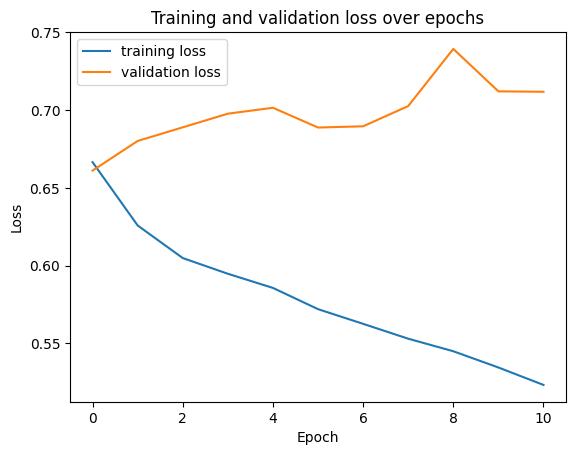

In [ ]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

In [383]:
import tensorflow as tf

In [384]:
# we first define a function that will be a scheduler and will permit to our learning rate to decrease over epochs
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [385]:
# we now implement our optimizer, chosen in the gridsearch part
from keras.optimizers import Adam

In [386]:
from keras.callbacks import LearningRateScheduler

In [387]:
gridsearch = {
    "batch" : [32, 64, 128],
    "dropout" : [0.3],
    "optimizer" : ["adam", "adagrad"],
}

In [388]:
def train_evaluate_lstm(params, X_train, X_val, y_train, y_val): 
        """Function that trains an lstm model given a list of params, a training set and 
        a validation set with their respective labels. It returns the mean of the validation
        accuracy."""

        initial_lr = 0.001  # the default starting learning rate for Adam and Adagrad
 
        patience = 10  

        # the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
        lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

        threshold = 0.5

        model = Sequential()
        model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
        model.add(Dropout(0.3))
        model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(4, activation='sigmoid'))

        # compile the model
        model.compile(loss='binary_crossentropy', optimizer=params["optimizer"], metrics=['accuracy'])

        history = model.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=params["batch"],
                verbose=1,
                callbacks=[early_stopping, lr_scheduler])

        y_pred_probs = model.predict(X_val)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_probs > threshold).astype(int)

        # print classification report
        print("Parameters:", params)
        print(classification_report(y_val, y_pred_binary))

        # calculate and return accuracy or other primary metric
        accuracy = accuracy_score(y_val, y_pred_binary)
        return accuracy

In [389]:
from itertools import product
from tqdm import tqdm

best_score = 0
best_params = None

# Create all combinations of parameters
param_combinations = [dict(zip(gridsearch.keys(), v)) for v in product(*gridsearch.values())]
for params in tqdm(param_combinations):
    score = train_evaluate_lstm(params, X_train, X_val, y_train, y_val)
    if score > best_score:
        best_score = score
        best_params = params

print("Best Score:", best_score)
print("Best Parameters:", best_params)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50
87/87 [==============================] - 40s 419ms/step - loss: 0.6389 - accuracy: 0.2509 - val_loss: 0.6784 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 31s 360ms/step - loss: 0.5999 - accuracy: 0.4108 - val_loss: 0.6856 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5845 - accuracy: 0.4671 - val_loss: 0.7064 - val_accuracy: 0.1885 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 31s 358ms/step - loss: 0.5691 - accuracy: 0.4610 - val_loss: 0.7106 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5598 - accuracy: 0.4747 - val_loss: 0.7120 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 31s 355ms/step - loss: 0.5393 - accuracy: 0.4726 - val_loss: 0.7260 - val_accuracy: 0.1751 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 31s 355ms/st

 17%|█▋        | 1/6 [05:58<29:54, 358.95s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       614
           1       0.42      0.93      0.58       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.61      0.89      0.73      3659
   macro avg       0.58      0.84      0.67      3659
weighted avg       0.63      0.89      0.73      3659
 samples avg       0.62      0.90      0.71      3659

Epoch 1/50
87/87 [==============================] - 36s 375ms/step - loss: 0.6998 - accuracy: 0.2755 - val_loss: 0.6931 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 30s 346ms/step - loss: 0.6974 - accuracy: 0.2664 - val_loss: 0.6910 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 30s 348ms/step - loss: 0.6945 - accuracy: 0.2628 - val_loss: 0.6892 - val_accuracy: 

 33%|███▎      | 2/6 [31:37<1:10:11, 1052.76s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
44/44 [==============================] - 42s 873ms/step - loss: 0.6760 - accuracy: 0.1560 - val_loss: 0.6723 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 39s 894ms/step - loss: 0.6488 - accuracy: 0.1097 - val_loss: 0.6685 - val_accuracy: 0.2367 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 39s 892ms/step - loss: 0.6454 - accuracy: 0.1069 - val_loss: 0.6663 - val_accurac

 50%|█████     | 3/6 [44:11<45:48, 916.21s/it]   

Epoch 1/50
44/44 [==============================] - 44s 925ms/step - loss: 0.6858 - accuracy: 0.3155 - val_loss: 0.6931 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 43s 984ms/step - loss: 0.6847 - accuracy: 0.3116 - val_loss: 0.6923 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 43s 989ms/step - loss: 0.6823 - accuracy: 0.3191 - val_loss: 0.6916 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6828 - accuracy: 0.3173 - val_loss: 0.6909 - val_accuracy: 0.2881 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6815 - accuracy: 0.3051 - val_loss: 0.6902 - val_accuracy: 0.2849 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 44s 996ms/step - loss: 0.6805 - accuracy: 0.3022 - val_loss: 0.6896 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 44s 992ms/st

 67%|██████▋   | 4/6 [1:20:35<47:13, 1416.94s/it]

Parameters: {'batch': 64, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
22/22 [==============================] - 56s 2s/step - loss: 0.6542 - accuracy: 0.1422 - val_loss: 0.6682 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 53s 2s/step - loss: 0.6187 - accuracy: 0.2892 - val_loss: 0.6783 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 52s 2s/step - loss: 0.6500 - accuracy: 0.3321 - val_loss: 0.6802 - val_accuracy: 0.1796

 83%|████████▎ | 5/6 [1:30:24<18:38, 1118.20s/it]

Parameters: {'batch': 128, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.38      0.81      0.52       614
           1       0.42      0.92      0.57       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.59      0.95      0.73      3659
   macro avg       0.58      0.93      0.70      3659
weighted avg       0.63      0.95      0.75      3659
 samples avg       0.59      0.96      0.71      3659

Epoch 1/50
22/22 [==============================] - 55s 2s/step - loss: 0.6967 - accuracy: 0.3271 - val_loss: 0.6993 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 51s 2s/step - loss: 0.6961 - accuracy: 0.3253 - val_loss: 0.6988 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 51s 2s/step - loss: 0.6954 - accuracy: 0.3256 - val_loss: 0.6983 - val_accuracy: 0.3401 -

100%|██████████| 6/6 [2:13:31<00:00, 1335.31s/it]

 {'batch': 128, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      0.99      0.56       614
           1       0.42      0.99      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      0.94      0.84      1204

   micro avg       0.58      0.98      0.73      3659
   macro avg       0.58      0.98      0.71      3659
weighted avg       0.63      0.98      0.75      3659
 samples avg       0.58      0.98      0.70      3659

Best Score: 0.11230964467005077
Best Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}


In [402]:
best_params = {'batch': 64, 'dropout': 0.7, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

y_pred_probs = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))


Epoch 1/50
44/44 [==============================] - 84s 2s/step - loss: 0.7192 - accuracy: 0.2224 - val_loss: 0.6842 - val_accuracy: 0.3039 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 76s 2s/step - loss: 0.6705 - accuracy: 0.1650 - val_loss: 0.6815 - val_accuracy: 0.3033 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 73s 2s/step - loss: 0.6652 - accuracy: 0.1495 - val_loss: 0.6800 - val_accuracy: 0.2602 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 73s 2s/step - loss: 0.6615 - accuracy: 0.1199 - val_loss: 0.6780 - val_accuracy: 0.2418 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 73s 2s/step - loss: 0.6531 - accuracy: 0.1072 - val_loss: 0.6745 - val_accuracy: 0.3071 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 73s 2s/step - loss: 0.6521 - accuracy: 0.1094 - val_loss: 0.6750 - val_accuracy: 0.3135 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 73s 2s/step - loss: 0.6544 - a

In [ ]:
import matplotlib.pyplot as plt

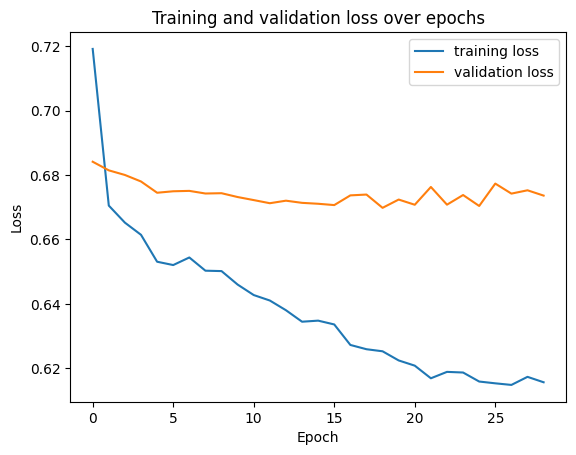

In [403]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()